# Model example

This example will show you the whole process from model testing, analysis, and SHAP.

Because data_preprocessing need raw data, so "example" folder has given you the output data and model.

> x_train.npy, x_test.npy, y_test.npy -> output of data_preprocessing

> model.pt -> model after training (model class and setting included in code)

If you didn't download the folder, must execute these two cells.

In [ ]:
!git clone https://github.com/YiChingLLin/Dinkle.git

Cloning into 'Dinkle'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 206 (delta 118), reused 146 (delta 61), pack-reused 0
Receiving objects: 100% (206/206), 7.74 MiB | 5.24 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
cd ./Dinkle/example/

/content/Dinkle/example/Dinkle/example


Start from here

In [ ]:
import pandas as pd
import numpy as np
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# # below is for loading data from google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

sequence_num = 100
partNo = "0162B00100" #料號編號
print("Sequence number: ", sequence_num)

# put your folder path, ex: '/content/drive/MyDrive/.../'
folder_path = './'

# put model name, ex: 'model.pt' for model path
model_path = folder_path + 'model.pt'

# put testing data and label npy file path, ex: 'x_test.npy', 'y_test.npy'
X_train = np.load(folder_path + 'x_train.npy')
X_test = np.load(folder_path + 'x_test.npy')
Y_test = np.load(folder_path + 'y_test.npy')
print(X_test.shape) #(testing_data_num, sequence_num, feature_num)
print(Y_test.shape) #(testing_data_num, output_num)

Sequence number:  100
(144, 100, 3)
(144, 26)


#Load model
Model class and setting for load model.
If you testing after training model, you can pass.

In [ ]:
"""
model class, should cpoy from training model
"""
class BiLSTM_layer(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, bidirectional, batch_first=False):
      super(BiLSTM_layer, self).__init__()
      self.lstm = nn.LSTM(
          input_size=input_size,
          hidden_size=hidden_size,
          num_layers=num_layers,
          bidirectional=bidirectional,
          batch_first=batch_first
      )

      self.fc = nn.Linear(hidden_size, 26)
      

  def forward(self, inputs):
      out, (h_n, c_n) = self.lstm(inputs, None)
      outputs = self.fc(torch.mean(h_n.squeeze(0), dim=0))

      return outputs

class DataEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(DataEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                              nn.ReLU(),
                              nn.Dropout(dropout),
                              nn.Linear(hidden_dim, output_dim)
                            )
  def forward(self, x):
    return self.net(x)

class minmax_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(minmax_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)
    

class outbound_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(outbound_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)
    
class DataonlyNet(nn.Module):
  def __init__(self, input_dim, output_dim, data_encoder, hidden_dim=4, n_layers=2, skip=False, input_type='state'):
    super(DataonlyNet, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    self.input_dim_decision_block = self.data_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim

      #self.net.append(nn.Linear(in_dim, out_dim))
      
      self.net.append(BiLSTM_layer(
              input_size=in_dim,
              hidden_size=64,
              num_layers=1,
              bidirectional=True,
              batch_first=True
          ))
      
      # self.net.append(nn.Flatten())
      # self.net.append(nn.Linear(64, 26))
      '''
      if i != n_layers-1:
        self.net.append(nn.ReLU())
      '''
      
    #self.net.append(nn.ReLU())
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.0):
    data_z = self.data_encoder(x)

    return data_z

  def forward(self, x, alpha=0.0):    
      data_z = self.data_encoder(x)
      z=data_z
      if self.skip:
        if self.input_type == 'seq':
          return self.net(z) + x[:,-1,:]
        else:
          return self.net(z) + x    
      else:
        return self.net(z) 

class Net(nn.Module):
  def __init__(self, input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=3, n_layers=1, merge='cat', skip=False, input_type='state'):
    super(Net, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.minmax_rule_encoder = minmax_rule_encoder
    self.outbound_rule_encoder = outbound_rule_encoder
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    assert self.minmax_rule_encoder.input_dim ==  self.data_encoder.input_dim
    assert self.minmax_rule_encoder.output_dim ==  self.data_encoder.output_dim
    self.merge = merge
    if merge == 'cat':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim * 3
    elif merge == 'add':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim

      #self.net.append(nn.Linear(in_dim, out_dim))
      
      self.net.append(BiLSTM_layer(
              input_size=in_dim,
              hidden_size=64,
              num_layers=1,
              bidirectional=True,
              batch_first=True
          ))
      
      # self.net.append(nn.Flatten())
      # self.net.append(nn.Linear(64, 26))
     
      
    #self.net.append(nn.ReLU())
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.1, beta=0.1):
    minmax_rule_z = self.minmax_rule_encoder(x)
    outbound_rule_z = self.outbound_rule_encoder(x)
    data_z = self.data_encoder(x)

    if self.merge=='add':
      z = alpha*minmax_rule_z + beta*outbound_rule_z + (1-alpha-beta)*data_z    # merge: Add
    elif self.merge=='cat':
      z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)    # merge: Concat
    elif self.merge=='equal_cat':
      z = torch.cat((minmax_rule_z,outbound_rule_z, data_z), dim=-1)    # merge: Concat

    return z

  def forward(self, x, alpha=0.1, beta=0.1):
      # merge: cat or add
      minmax_rule_z = self.minmax_rule_encoder(x)
      outbound_rule_z = self.outbound_rule_encoder(x)
      data_z = self.data_encoder(x)

      if self.merge=='add':
        z = alpha*minmax_rule_z + beta*outbound_rule_z + (1-alpha-beta)*data_z    # merge: Add
      elif self.merge=='cat':
        z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)    # merge: Concat
      elif self.merge=='equal_cat':
        z = torch.cat((minmax_rule_z, outbound_rule_z, data_z), dim=-1)    # merge: Concat
      else:
        print(self.merge)
      
      # z = torch.flatten(z, start_dim=1)

      if self.skip:
        if self.input_type == 'seq':
          return self.net(z) + x[:,-1,:]
        else:
          return self.net(z) + x    
      else:
        return self.net(z) 
        
        try:
          return self.net(z)   
        except:
          print(type(z))
          print(z.shape)

In [ ]:
"""
model setting, should cpoy from training model
"""
merge = 'cat'

input_dim = 3
input_dim_encoder = 3
output_dim_encoder = 2
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim_encoder = output_dim_encoder
hidden_dim_encoder = hidden_dim_encoder
hidden_dim_db = hidden_dim_db
output_dim = 26
n_layers = 1
use_type=''


outbound_rule_encoder = outbound_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.3)
minmax_rule_encoder = minmax_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.3)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.3)

if use_type=='no_rule':
  model = Net(input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge)
else:
  model =DataonlyNet (input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers)

In [ ]:
"""
Load model, and change X_test to tensor
"""
model = torch.load(model_path)
model.eval()

X_test = torch.tensor(X_test).to(torch.float32)

#Testing

In [ ]:
with torch.no_grad():
  pred = model(X_test, alpha=0.1, beta=0.1)

In [ ]:
"""
規格判斷, data可以是真實或預測結果, partNo為料號編號
"""
def measure_std(data, partNo):
  measure = []
  for data_num in range(len(data)):
    partNo = partNo
    if partNo == "0162B00100":
      max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    elif partNo == "0162B01100":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B01100-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    else:
      return "Error"

    wrong = False
    for detail_num in range(13):
      if data[data_num][detail_num] > max_std[detail_num] or data[data_num][detail_num] < min_std[detail_num]:
        wrong = True
      
      if data[data_num][detail_num+13] > max_std[detail_num] or data[data_num][detail_num+13] < min_std[detail_num]: 
        wrong = True

    if wrong == True:
      measure.append(0) # notok
    else:
      measure.append(1) # ok

  return measure

In [ ]:
"""
將所有資料以dataframe形式存入csv中
欄位0~299為data, true+編號 為真實值, pred+編號 為預測值,
 measure_true為真實良品/不良品, measure_pred為預測良品/不良品
"""
df = pd.DataFrame(X_test.reshape(-1, sequence_num*3).numpy())
y_df = pd.DataFrame(Y_test)
p_df = pd.DataFrame(pred.numpy())

for i in range(26):
  df['true'+str(i+1)] = y_df[i]
  df['pred'+str(i+1)] = p_df[i]

measure_true = np.array(measure_std(Y_test, partNo))
measure_pred = np.array(measure_std(pred, partNo))

df['measure_true'] = measure_true
df['measure_pred'] = measure_pred

df.to_csv(folder_path +"/test.csv", header=True, index=True) 
print(df.head(10))

       0    1         2      3    4         5      6    7         8      9  \
0  321.0  2.0  5.366667  321.0  2.0  5.350000  321.0  2.0  5.350000  321.0   
1  330.0  2.0  2.866667  346.0  1.0  3.966667  330.0  2.0  5.483333  330.0   
2  310.0  2.0  5.150000  310.0  2.0  5.183333  310.0  2.0  0.183333  325.0   
3  310.0  2.0  5.133333  310.0  2.0  5.150000  310.0  2.0  5.116667  310.0   
4  310.0  2.0  5.133333  310.0  2.0  5.183333  310.0  2.0  2.950000  325.0   
5  325.0  1.0  0.950000  310.0  2.0  5.133333  310.0  2.0  5.150000  310.0   
6  310.0  2.0  5.150000  310.0  2.0  5.150000  310.0  2.0  5.166667  310.0   
7  321.0  1.0  5.366667  321.0  2.0  2.833333  348.0  1.0  3.083333  188.0   
8   52.0  4.0  0.016667  224.0  4.0  0.016667  421.0  1.0  0.900000  401.0   
9  351.0  1.0  4.116667  334.0  2.0  5.566667  334.0  2.0  5.566667  334.0   

   ...  true23    pred23  true24    pred24  true25    pred25  true26  \
0  ...   0.546  0.573602   0.553  0.559123   0.551  0.554407   0.543 

In [ ]:
"""
計算個數及準確率
整體準確率 = (真實良品&預測良品筆數 + 真實不良品&預測不良品筆數) / 總筆數 
良品準確率 = 真實良品&預測良品筆數  / 真實良品筆數 
不良品準確率 = 真實不良品&預測不良品筆數  / 真實不良品筆數
"""
test_measure_ok=0
pred_measure_ok=0
test_measure_nok=0
pred_measure_nok=0
test_measure_ok_arr=[]
pred_measure_ok_arr=[]
X_test_correct=[]
X_test_wrong=[]

for test_num in range(len(X_test)):
  if measure_true[test_num]==1:
    test_measure_ok +=1
    test_measure_ok_arr.append(1)
    if measure_pred[test_num]==1:
      pred_measure_ok +=1
      pred_measure_ok_arr.append(1)
      X_test_correct.append(X_test[test_num].numpy())
    else:
      pred_measure_ok_arr.append(0)
      X_test_wrong.append(X_test[test_num].numpy())
     
  else:
    test_measure_nok +=1
    test_measure_ok_arr.append(0)
    if measure_pred[test_num]==1:
      pred_measure_ok_arr.append(1)
      X_test_wrong.append(X_test[test_num].numpy())
    else:
      pred_measure_nok +=1
      pred_measure_ok_arr.append(0)
      X_test_correct.append(X_test[test_num].numpy())


print("實際值良品：",test_measure_ok,"個")
print("實際值良品 & 預測值良品：",pred_measure_ok,"個")
print("良品預測準確率：",pred_measure_ok/test_measure_ok)
print()
print("實際值不良品：",test_measure_nok,"個")
print("實際值不良品 & 預測值不良品：",pred_measure_nok,"個")
if test_measure_nok != 0:
  print("不良品預測準確率：",pred_measure_nok/test_measure_nok)
else:
  print("不良品預測準確率：","無不良品")
print()
print("準確率：",(pred_measure_ok+pred_measure_nok)/len(X_test))

實際值良品： 143 個
實際值良品 & 預測值良品： 140 個
良品預測準確率： 0.9790209790209791

實際值不良品： 1 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 0.0

準確率： 0.9722222222222222


In [ ]:
"""
將預測正確與錯誤之data另外儲存
"""
np.save(folder_path + 'x_test_correct.npy', X_test_correct)
np.save(folder_path + 'x_test_wrong.npy', X_test_wrong)
print("Correct num:", len(X_test_correct))
print("Wrong num:", len(X_test_wrong))

Correct num: 140
Wrong num: 4


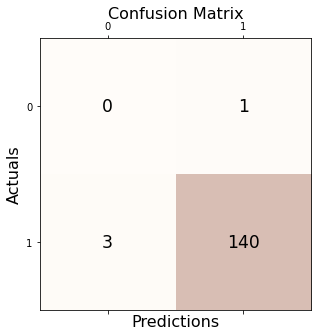

In [ ]:
"""
Show testing confusion matrix
0為不良品, 1為良品
"""
conf_matrix = confusion_matrix(y_true=test_measure_ok_arr, y_pred=pred_measure_ok_arr)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

#Analysis

##Confusion matrix for each detail

In [ ]:
# put testing data and output file path, ex: 'test.csv'
data_all = pd.read_csv(folder_path+'test.csv')

"""
將csv檔案內資料整理為np array
"""
measure_true = data_all['measure_true'] #真實良品/不良品
measure_pred = data_all['measure_pred'] #預測良品/不良品

true_name = []
pred_name = []
for i in range(1,27):
  true_name.append('true'+str(i))
  pred_name.append('pred'+str(i))

Y_test = pd.DataFrame()
pred = pd.DataFrame()
for num in range(26):
  Y_test = pd.concat([Y_test, data_all[true_name[num]]],axis=1) #真實值
  pred = pd.concat([pred, data_all[pred_name[num]]],axis=1)     #預測值

Y_test = np.array(Y_test)
pred = np.array(pred)

print(measure_true.shape) #(data_num)
print(measure_pred.shape) #(data_num)
print(Y_test.shape)       #(data_num, output_num)
print(pred.shape)         #(data_num, output_num)

(144,)
(144,)
(144, 26)
(144, 26)


In [ ]:
"""
規格判斷 for detail, 以單筆資料判斷良品/不良品
data可以是真實或預測結果, partNo為料號編號, num為資料編號
"""
def measure_std_detail(data, partNo, num):
  detail_num = num
  partNo = partNo
  if partNo == "0162B00100":
    max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B00200":
    max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B00200-1":
    max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
    min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

  elif partNo == "0162B01100":
    max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B01100-1":
    max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
    min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

  else:
    return "Error"

  wrong = False

  if data[detail_num] > max_std[detail_num] or data[detail_num] < min_std[detail_num]:
    wrong = True
  
  if data[detail_num+13] > max_std[detail_num] or data[detail_num+13] < min_std[detail_num]: 
    wrong = True

  return wrong #不良品=True, 良品=False

detail  1
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


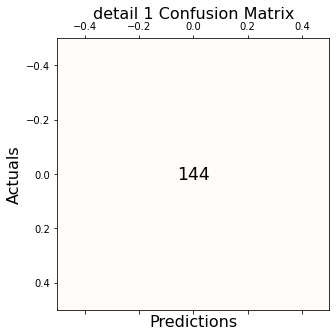

detail  2
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


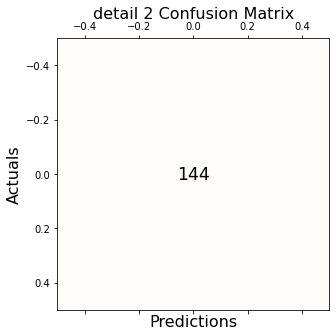

detail  3
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


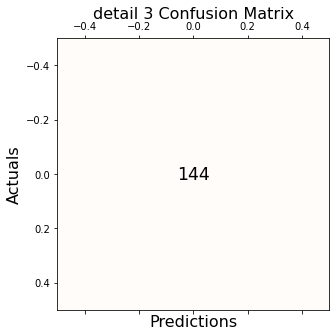

detail  4
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


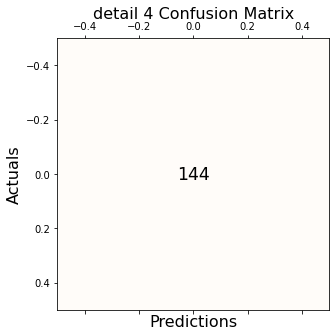

detail  5
實際值良品： 143 個
實際值良品 & 預測值良品： 143 個
良品預測準確率： 1.0

實際值不良品： 1 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 0.0

準確率： 0.9930555555555556


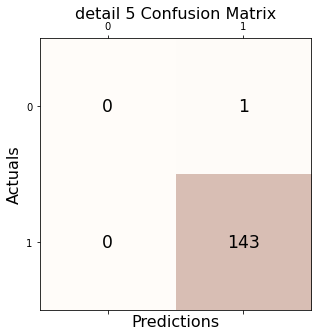

detail  6
實際值良品： 144 個
實際值良品 & 預測值良品： 141 個
良品預測準確率： 0.9791666666666666

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 0.9791666666666666


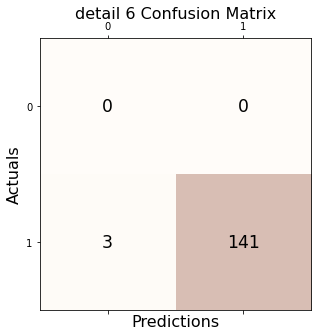

detail  7
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


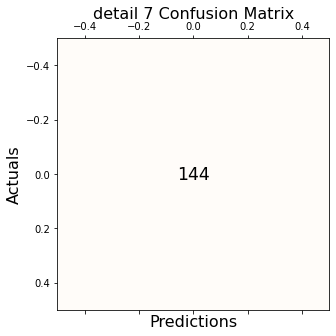

detail  8
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


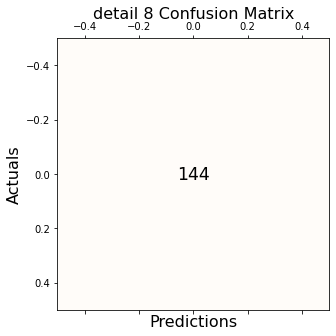

detail  9
實際值良品： 144 個
實際值良品 & 預測值良品： 143 個
良品預測準確率： 0.9930555555555556

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 0.9930555555555556


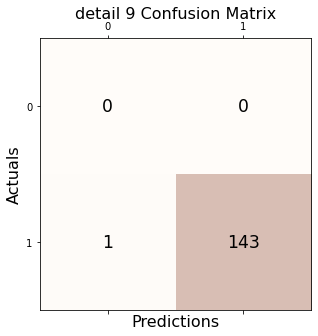

detail  10
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


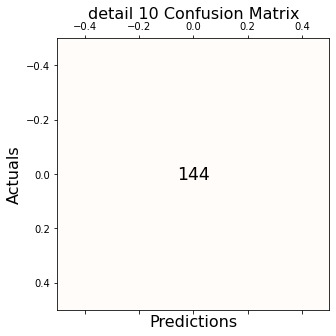

detail  11
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


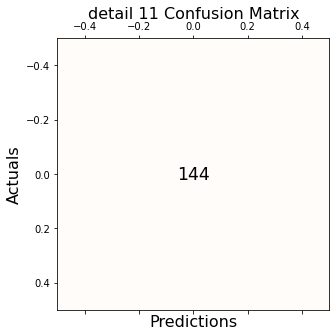

detail  12
實際值良品： 144 個
實際值良品 & 預測值良品： 143 個
良品預測準確率： 0.9930555555555556

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 0.9930555555555556


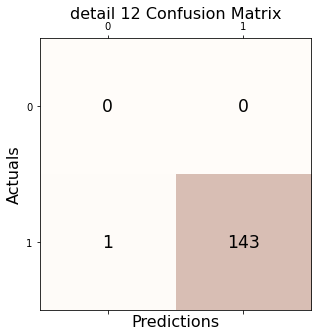

detail  13
實際值良品： 144 個
實際值良品 & 預測值良品： 144 個
良品預測準確率： 1.0

實際值不良品： 0 個
實際值不良品 & 預測值不良品： 0 個
不良品預測準確率： 無不良品

準確率： 1.0


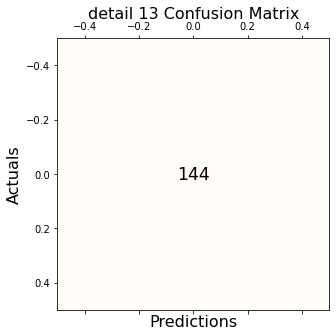

In [ ]:
"""
計算各detail的個數及準確率, confusion matrix
整體準確率 = (真實良品&預測良品筆數 + 真實不良品&預測不良品筆數) / 總筆數 
良品準確率 = 真實良品&預測良品筆數  / 真實良品筆數 
不良品準確率 = 真實不良品&預測不良品筆數  / 真實不良品筆數
"""
for detail_num in range(13):
  print("detail ", detail_num+1)
  test_measure_ok=0
  pred_measure_ok=0
  test_measure_nok=0
  pred_measure_nok=0
  test_measure_ok_arr=[]
  pred_measure_ok_arr=[]

  for test_num in range(len(Y_test)):
    if measure_std_detail(Y_test[test_num], partNo, detail_num)==False:
      test_measure_ok +=1
      test_measure_ok_arr.append(1)
      if measure_std_detail(pred[test_num], partNo, detail_num)==False:
        pred_measure_ok +=1
        pred_measure_ok_arr.append(1)
      else:
        pred_measure_ok_arr.append(0)
      
    else:
      test_measure_nok +=1
      test_measure_ok_arr.append(0)
      if measure_std_detail(pred[test_num], partNo, detail_num)==False:
        pred_measure_ok_arr.append(1)
      else:
        pred_measure_nok +=1
        pred_measure_ok_arr.append(0)

  print("實際值良品：",test_measure_ok,"個")
  print("實際值良品 & 預測值良品：",pred_measure_ok,"個")
  print("良品預測準確率：",pred_measure_ok/test_measure_ok)
  print()
  print("實際值不良品：",test_measure_nok,"個")
  print("實際值不良品 & 預測值不良品：",pred_measure_nok,"個")
  if test_measure_nok != 0:
    print("不良品預測準確率：",pred_measure_nok/test_measure_nok)
  else:
    print("不良品預測準確率：","無不良品")
  print()
  print("準確率：",(pred_measure_ok+pred_measure_nok)/len(Y_test))

  """
  Show confusion matrix for each detail
  0為不良品, 1為良品
  """
  conf_matrix = confusion_matrix(y_true=test_measure_ok_arr, y_pred=pred_measure_ok_arr)
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predictions', fontsize=16)
  plt.ylabel('Actuals', fontsize=16)
  plt.title('detail '+str(detail_num+1)+' Confusion Matrix', fontsize=16)
  # plt.savefig(folder_path+'cm_detail'+str(detail_num+1)+'.jpg')
  plt.show()

##Error distribution histogram

In [ ]:
"""
Error distribution histogram
"""
def detail_wrong_pic(detail_00_max, detail_00_min, detail_01_max, detail_01_min, detail_10_max, detail_10_min):
  plt.figure(figsize=(12,4))
  labels=[]

  for i in range(1,14):
    labels.append("detail"+str(i))

  x = np.arange(1,14)
  width = 0.25

  plt.bar(x - width/2, detail_01_max, color="lightblue",label="true > std(max)",width= 0.25)
  plt.bar(x + width/2, detail_01_min, color="lightgrey",label="true < std(min)",width= 0.25)
  plt.bar(x - width/2, detail_00_max, bottom = detail_01_max, color="steelblue",label="true > std & pred > std(max)",width= 0.25)
  plt.bar(x + width/2, detail_00_min, bottom = detail_01_min, color="dimgrey",label="true < std & pred < std(min)", tick_label=labels,width= 0.25)
  plt.bar(x - width/2, detail_10_max, bottom = detail_00_max+detail_01_max, color="lightsteelblue",label="pred > std(max)",width= 0.25)
  plt.bar(x + width/2, detail_10_min, bottom = detail_00_min+detail_01_min, color="darkgrey",label="pred < std(min)",width= 0.25)
  plt.legend(loc='upper left')
  # plt.savefig(folder_path+'detail_wrong.jpg')
  plt.show()

In [ ]:
"""
規格判斷, 計算 真實不良&預測不良, 真實不良&預測良, 真實良&預測不良
"""
def measure_std(partNo):
  measure = []
  
  for data_num in range(len(Y_test)):
    partNo = partNo
    if partNo == "0162B00100":
      max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    elif partNo == "0162B01100":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B01100-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    else:
      return "Error"
  
    #真實不良 預測不良
    for detail_num in range(13):
      if (Y_test[data_num][detail_num] > max_std[detail_num] and pred[data_num][detail_num] > max_std[detail_num]):
        detail_00_max_wrong[detail_num] += 1
      
      if (Y_test[data_num][detail_num+13] < min_std[detail_num] and pred[data_num][detail_num+13] < min_std[detail_num]):
        detail_00_min_wrong[detail_num] += 1

    #真實不良 預測良
      if (Y_test[data_num][detail_num] > max_std[detail_num] and pred[data_num][detail_num] <= max_std[detail_num]):   
        detail_01_max_wrong[detail_num] += 1
      
      if (Y_test[data_num][detail_num+13] < min_std[detail_num] and pred[data_num][detail_num+13] >= min_std[detail_num]):   
        detail_01_min_wrong[detail_num] += 1
    
    #真實良 預測不良
      if (Y_test[data_num][detail_num] <= max_std[detail_num] and pred[data_num][detail_num] > max_std[detail_num]): 
        detail_10_max_wrong[detail_num] += 1
      if (Y_test[data_num][detail_num+13] >= min_std[detail_num] and pred[data_num][detail_num+13] < min_std[detail_num]):
        detail_10_min_wrong[detail_num] += 1

  return measure

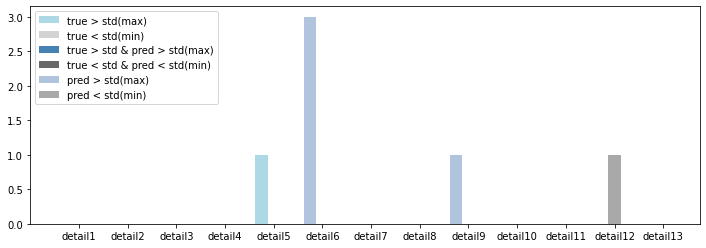

In [ ]:
"""
Execute example
"""
detail_00_max_wrong = np.zeros(13)
detail_00_min_wrong = np.zeros(13)
detail_01_max_wrong = np.zeros(13)
detail_01_min_wrong = np.zeros(13)
detail_10_max_wrong = np.zeros(13)
detail_10_min_wrong = np.zeros(13)

measure_std(partNo)
detail_wrong_pic(detail_00_max_wrong, detail_00_min_wrong, detail_01_max_wrong, detail_01_min_wrong, detail_10_max_wrong, detail_10_min_wrong)

#SHAP 

In [ ]:
"""
SHAP calculator, using SHAP github: https://github.com/slundberg/shap
And save the 'shap.npy' for analysis
"""
!pip install shap
import shap

def shap_calculator(train, test):
  X_train = torch.tensor(train).to(torch.float32)
  X_test = torch.tensor(test).to(torch.float32)
  print(X_test.shape)
  features = ['Speed', 'Status', 'Frequency']

  #should only something like 100 or 1000 random background samples, not the whole training dataset.
  explainer = shap.DeepExplainer(model, X_train[:100]) 
  shap_values_all = explainer.shap_values(X_test)

  np.save(folder_path+'shap.npy', shap_values_all)

  X = np.array(shap_values_all).reshape(-1,sequence_num,3) #reshape the data for plot
  print(X.shape)

  shap.summary_plot(X[:, 0, :], X_test[:][:, 0, :], plot_type="bar", feature_names = features, plot_size=(15,5))

torch.Size([144, 100, 3])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.


(3744, 100, 3)


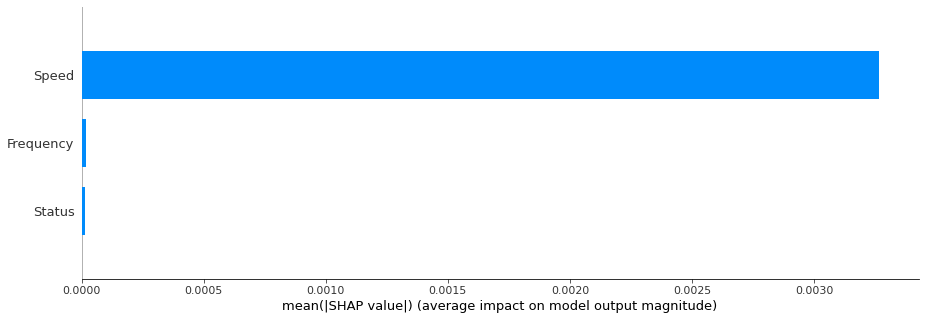

In [ ]:
"""
SHAP calculator using 'x_test.npy' for example
"""
X_test = np.load(folder_path + 'x_test.npy')
shap_calculator(X_train, X_test)

#SHAP heatmap picture from load data

In [ ]:
"""
Calculator each feature SHAP value, and the sum of SHAP value
"""
import seaborn as sns

def shap_feature_calculator(load=True):
  if load:
    folder_path = folder
    file_name = fname
    shap_values_all = np.load(folder_path+str(file_name))

  shap_value = np.array(abs(shap_values_all))
  shap_values = np.sum(shap_value, axis=1)
  shap_values = np.sum(shap_values, axis=0)
  shap_values = np.sum(shap_values, axis=0)

  num = 0
  
  for num in range(len(shap_values)):
    value = shap_values[num]
    values.append(value)

  shap_values_sum = np.sum(shap_value)

  return shap_values_sum

"""
Show the heatmap of feature and sequence
"""
def shap_feature_sequence(load=True):
  if load:
    folder_path = folder
    file_name = fname
    shap_values_all = np.load(folder_path+str(file_name))

  shap_values_sum = shap_feature_calculator()

  shap_value = np.array(abs(shap_values_all))
  shap_values = np.sum(shap_value, axis=1)
  shap_values = np.sum(shap_values, axis=0)

  plt.figure(figsize=(20,2)) 
  sns.heatmap(shap_values.T, linewidth=0.0,cmap="Blues",yticklabels =['Speed', 'Status', 'Frequency'])
  plt.xlabel("Sequence")
  plt.show()

  for num in range(len(values)):
    value = values[num]/shap_values_sum
    print('Feature {0:10}:   {1:10.5f} %'.format(features[num], value*100))

"""
Show the heatmap of feature and data
"""
def shap_feature_data(load=True):
  if load:
    folder_path = folder
    file_name = fname
    shap_values_all = np.load(folder_path+str(file_name))
  
  shap_value = np.array(abs(shap_values_all))
  shap_values = np.sum(shap_value, axis=2)
  shap_values = np.sum(shap_values, axis=0)

  plt.figure(figsize=(20,2)) 
  sns.heatmap(shap_values.T, linewidth=0.0,cmap="Blues",yticklabels =['Speed', 'Status', 'Frequency'])
  plt.xlabel("Data")
  plt.show()

"""
Show the heatmap of feature and detail
"""
def shap_feature_detail(load=True):
  if load:
    folder_path = folder
    file_name = fname
    shap_values_all = np.load(folder_path+str(file_name))
  
  shap_value = np.array(abs(shap_values_all))
  shap_values = np.sum(shap_value, axis=1)
  shap_values = np.sum(shap_values, axis=1)

  shap_values_add = np.add(shap_values[0:13], shap_values[13:26])

  plt.figure(figsize=(20,2)) 
  sns.heatmap(shap_values_add.T, linewidth=0.0,cmap="Blues", xticklabels=detail, yticklabels =['Speed', 'Status', 'Frequency'])
  plt.xlabel("detail")
  plt.show()

  detail_value_sum = np.sum(shap_values_add, axis=1)

  for i in range(13):
    print("detail"+str(i+1))
    for num in range(3):
      value = shap_values_add[i][num]/detail_value_sum[i]
      print('Feature {0:10}:   {1:10.5f} %'.format(features[num], value*100))

"""
Show the heatmap of data and sequence
"""
def shap_data_sequence(load=True):
  if load:
    folder_path = folder
    file_name = fname
    shap_values_all = np.load(folder_path+str(file_name))

  shap_value = np.array(abs(shap_values_all))
  shap_values = np.sum(shap_value, axis=3)
  shap_values = np.sum(shap_values, axis=0)

  plt.figure(figsize=(20,5)) 
  sns.heatmap(shap_values, linewidth=0.0,cmap="Blues", yticklabels=False)
  plt.xlabel("Sequence")
  plt.ylabel("Data")
  plt.show()

"""
Show the heatmap of detail and sequence
"""
def shap_detail_sequence(load=True):
  if load:
    folder_path = folder
    file_name = fname
    shap_values_all = np.load(folder_path+str(file_name))

  shap_value = np.array(abs(shap_values_all))
  shap_values = np.sum(shap_value, axis=1)
  shap_values = np.sum(shap_values, axis=2)

  shap_values_add = np.add(shap_values[0:13], shap_values[13:26])

  plt.figure(figsize=(20,5)) 
  sns.heatmap(shap_values[0:13], linewidth=0.0,cmap="Blues", yticklabels=detail)
  plt.xlabel("Sequence")
  plt.ylabel("detail max")
  plt.show()

  plt.figure(figsize=(20,5)) 
  sns.heatmap(shap_values[13:26], linewidth=0.0,cmap="Blues", yticklabels=detail)
  plt.xlabel("Sequence")
  plt.ylabel("detail min")
  plt.show()

  plt.figure(figsize=(20,5)) 
  sns.heatmap(shap_values_add, linewidth=0.0,cmap="Blues", yticklabels=detail)
  plt.xlabel("Sequence")
  plt.ylabel("detail")
  plt.show()

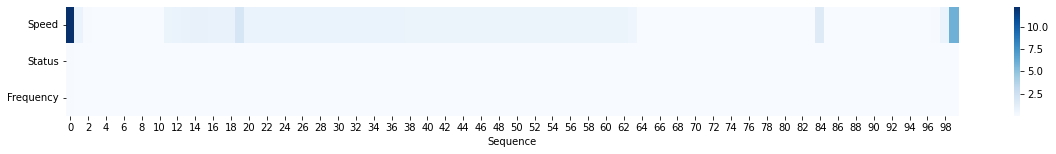

Feature Speed     :     98.65703 %
Feature Status    :      0.55220 %
Feature Frequency :      0.79076 %


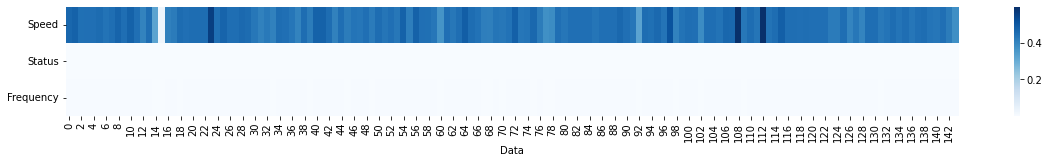

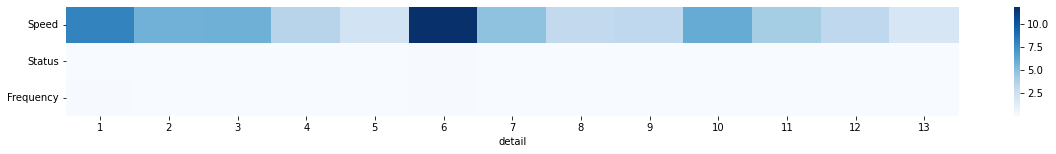

detail1
Feature Speed     :     98.62246 %
Feature Status    :      0.54904 %
Feature Frequency :      0.82851 %
detail2
Feature Speed     :     98.58638 %
Feature Status    :      0.58115 %
Feature Frequency :      0.83247 %
detail3
Feature Speed     :     98.65375 %
Feature Status    :      0.59681 %
Feature Frequency :      0.74944 %
detail4
Feature Speed     :     98.74762 %
Feature Status    :      0.49875 %
Feature Frequency :      0.75363 %
detail5
Feature Speed     :     98.80349 %
Feature Status    :      0.50007 %
Feature Frequency :      0.69644 %
detail6
Feature Speed     :     98.63087 %
Feature Status    :      0.58450 %
Feature Frequency :      0.78463 %
detail7
Feature Speed     :     98.68460 %
Feature Status    :      0.53459 %
Feature Frequency :      0.78082 %
detail8
Feature Speed     :     98.63263 %
Feature Status    :      0.56904 %
Feature Frequency :      0.79834 %
detail9
Feature Speed     :     98.79868 %
Feature Status    :      0.52259 %
Feature Frequency 

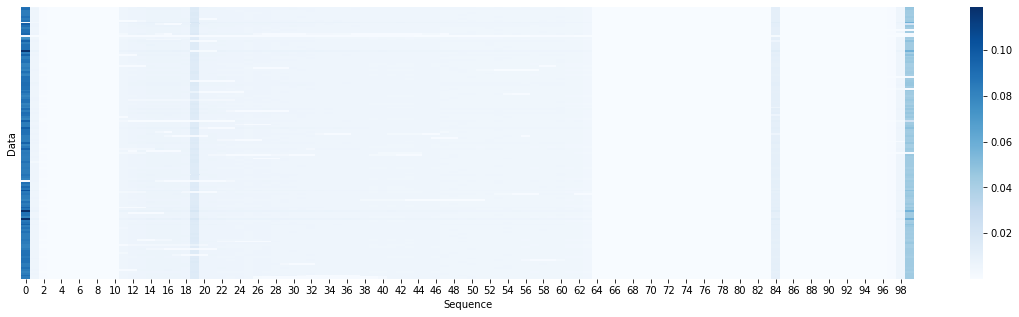

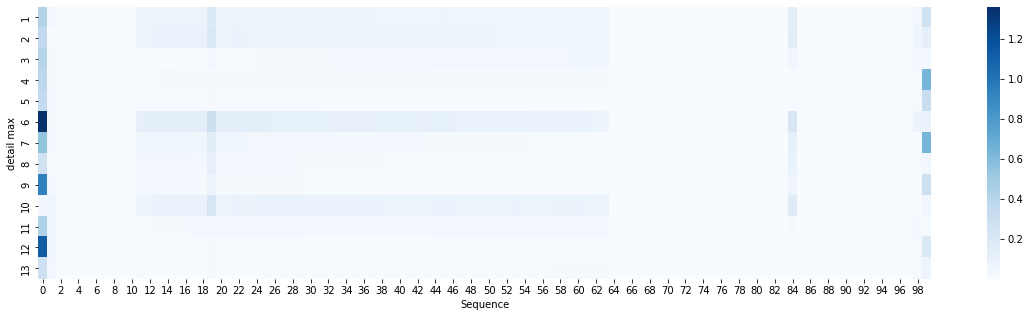

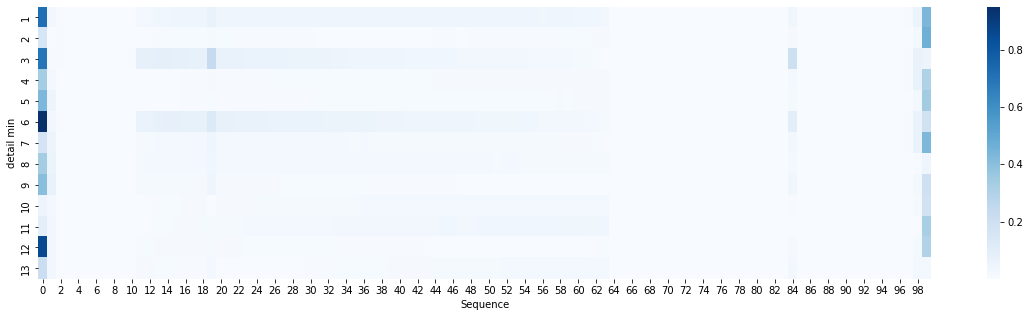

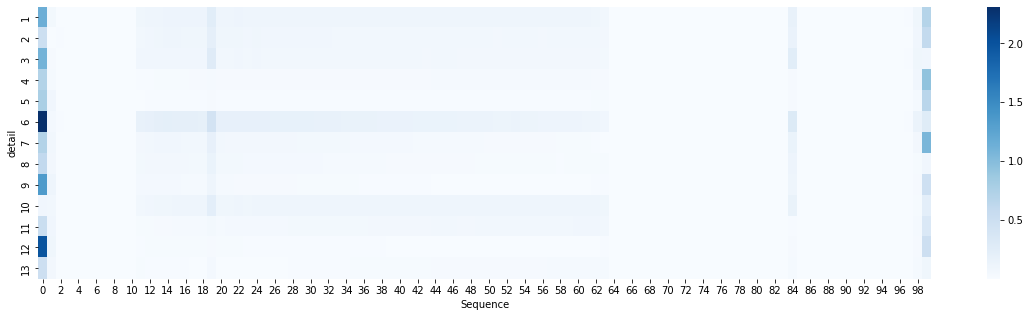

In [ ]:
"""
using 'shap.npy' from 'x_test.npy' for example
"""
values = []
shap_values_sum = 0
features = ['Speed', 'Status', 'Frequency']
detail = []
for i in range(1,14):
  detail.append(str(i))

sequence_num = 100

# put shap npy file path, ex: 'shap.npy'
folder = folder_path
fname = 'shap.npy'
  
shap_feature_sequence(load=True)
shap_feature_data(load=True)
shap_feature_detail(load=True)
shap_data_sequence(load=True)
shap_detail_sequence(load=True)